# TCN Model on Lab p4679
Author: Camilla Billari <br> 
Date: 07/02/24

Fitting a TCN to the lab p4679 dataset.

In [26]:
# Import relevant libraries
import matplotlib.pyplot as plt

from scripts.models.tcn_oneshot_multistep import MultiStepTCN
from utils.data_preprocessing import (
    compare_feature_statistics,
    create_dataset,
    moving_average_causal_filter,
    normalise_dataset,
    split_train_test_forecast_windows,
)

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

# from utils.nn_io import load_model, save_model
from utils.general_functions import set_seed, set_torch_device
from utils.nn_train import eval_model_on_test_set, train_model
from utils.plotting import (
    plot_all_data_results,
    plot_example_sample,
    plot_metric_results,
    plot_original_vs_processed_data,
    plot_single_seg_result,
)

In [27]:
# Set random seed
SEED = 17  # random seed for the dataset and model
set_seed(SEED)

# Set torch device
device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


## Load Data

In [28]:
EXP = "p4679"  # select Marone p4679 experiment

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,time
0,5.091520,6.986740,22107.1104,0.000
1,5.090652,6.988410,22109.7823,0.001
2,5.089989,6.986299,22103.7900,0.002
3,5.089492,6.985970,22109.2161,0.003
4,5.088243,6.987547,22108.5900,0.004


In [29]:
# Select segment average and scale down by 10^8
shear_stress_df = df["obs_shear_stress"]

shear_stress_df.shape

(301721,)

## Data Pre-processing

### Denoising

In [37]:
# Data smoothing
SMOOTHING_WINDOW = 80  # moving average window size
DOWNSAMPLING_FACTOR = 80

# Smooth the data
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)

df_smoothed.shape

(3771,)

In [38]:
# Check if smoothed results are statistically significantly different
results = compare_feature_statistics(shear_stress_df, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': -0.004006564093548179, 'p_value': 0.9968032355367317, 'significant': False}, 'variance_comparison': {'f_statistic': 1.6052555845284485e-05, 'p_value': 0.9968032338394794, 'significant': False}}


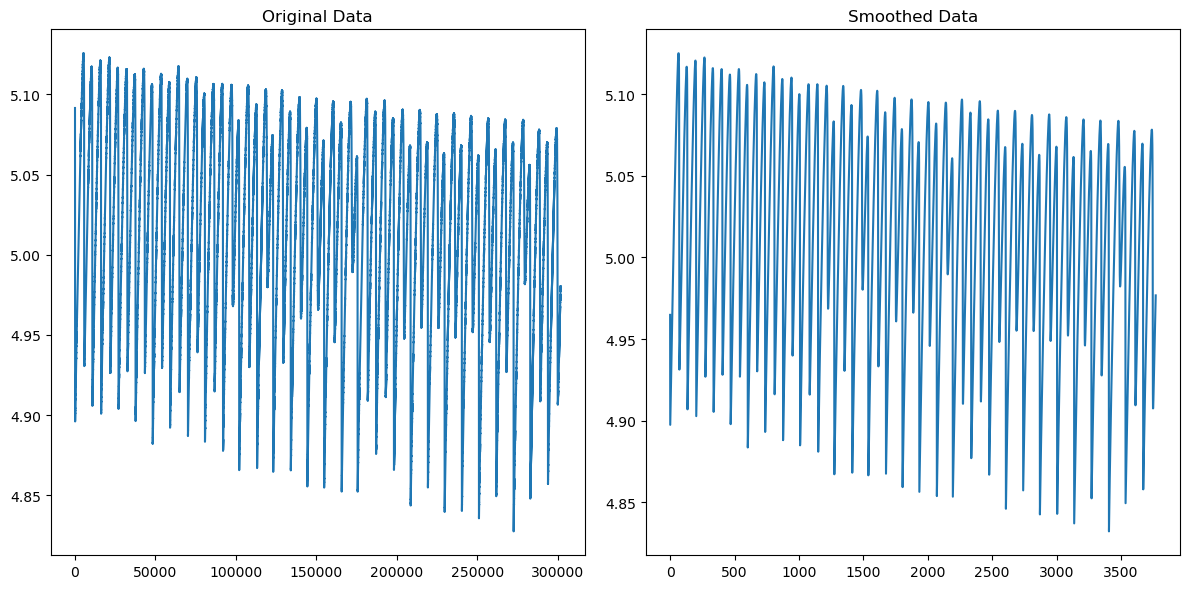

In [39]:
plot_original_vs_processed_data(shear_stress_df, df_smoothed, "line")

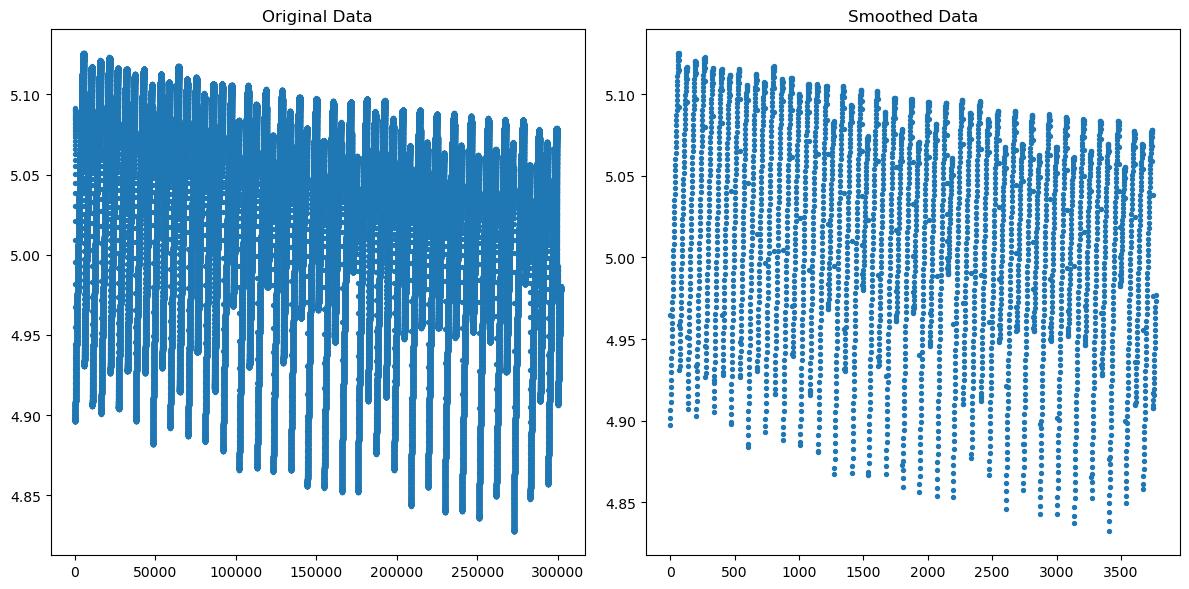

In [40]:
plot_original_vs_processed_data(shear_stress_df, df_smoothed, "scatter")

## Creating the datastet

In [41]:
# Dataset parameters
LOOKBACK, FORECAST = 180, 30  # lookback and forecast values
N_FORECAST_WINDOWS = 15  # n forecasted windows in test set
N_VALIDATION_WINDOWS = 15  # n forecasted windows in validation set

# Pre-process the data into windows
X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([3562, 180]), torch.Size([3562, 30])


In [42]:
# Split into train and test sets and normalise it
(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
) = split_train_test_forecast_windows(
    X, y, FORECAST, N_FORECAST_WINDOWS, N_VALIDATION_WINDOWS
)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")
print(f"Validation data shapes: {X_val.shape}, {y_val.shape}")

Training data shapes: torch.Size([2640, 180]), torch.Size([2640, 30])
Testing data shapes: torch.Size([450, 180]), torch.Size([450, 30])
Validation data shapes: torch.Size([450, 180]), torch.Size([450, 30])


### Normalising with scaler based on the training set

In [43]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = normalise_dataset(
    X_train, y_train, X_test, y_test, X_val, y_val
)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc', 'X_val', 'y_val', 'X_val_sc', 'y_val_sc'])


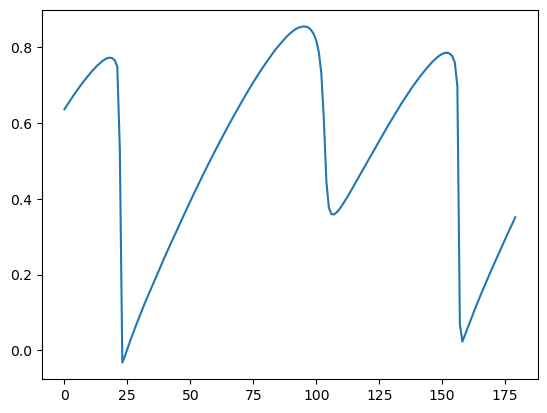

In [44]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

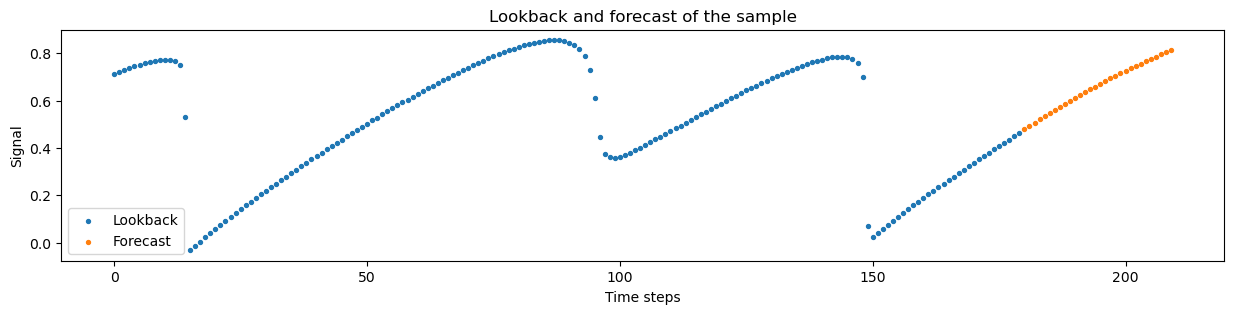

In [45]:
plot_example_sample(
    data_dict["X_test_sc"], data_dict["y_test_sc"], 10, LOOKBACK, FORECAST
)

## Modelling

In [46]:
# For TCN config
N_VARIATES = 1
HIDDEN_SIZE = 50
KERNEL_SIZE = 3
OUTPUT_SIZE = FORECAST
DROPOUT = 0

model = MultiStepTCN(
    N_VARIATES, LOOKBACK, OUTPUT_SIZE, [HIDDEN_SIZE], KERNEL_SIZE, DROPOUT
).to(device)

### Training

In [47]:
# For TCN training
N_EPOCHS = 75
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

Training model on cuda


Epoch [75/75], Train RMSE: 0.0193, Val RMSE: 0.0245: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s]


In [48]:
results_dict = eval_model_on_test_set(
    model, results_dict, data_dict, scaler_y, device
)

## Results

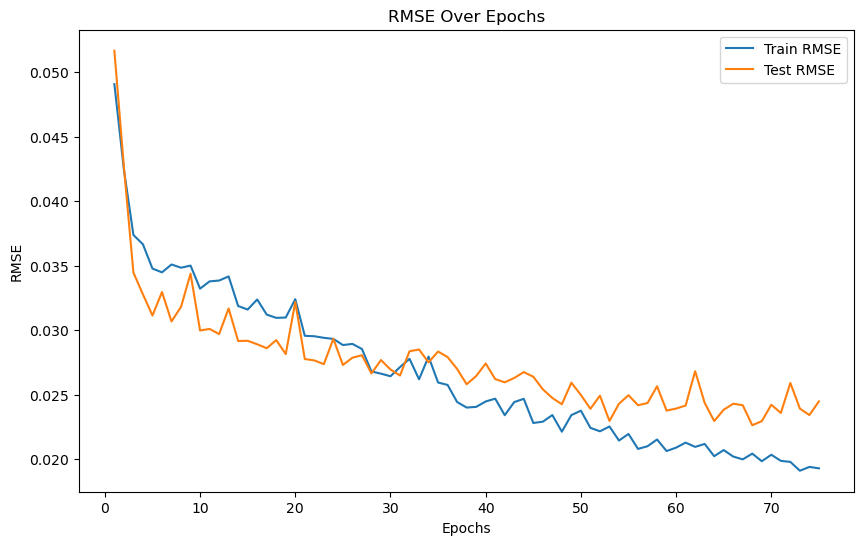

In [49]:
# Plot RMSE
plot_metric_results(
    N_EPOCHS,
    results_dict["train_rmse_list"],
    results_dict["val_rmse_list"],
    "RMSE",
)

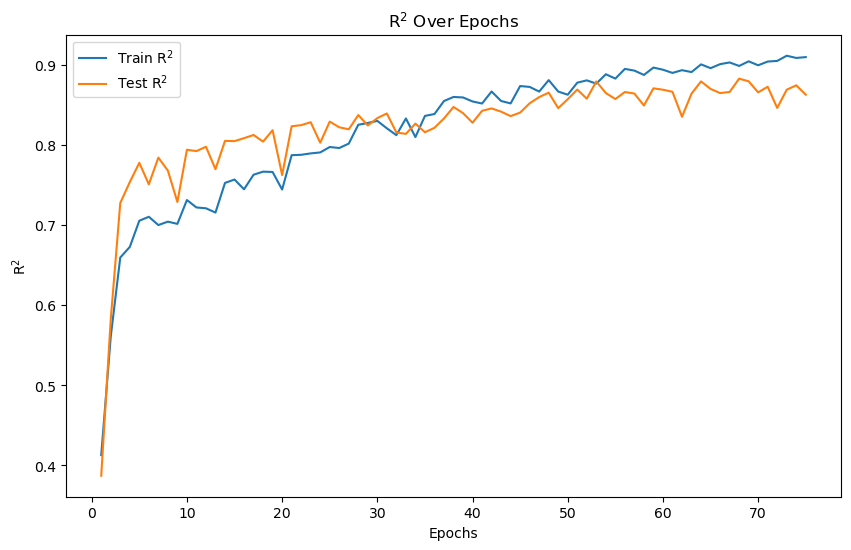

In [50]:
# Plot R2
plot_metric_results(
    N_EPOCHS,
    results_dict["train_r2_list"],
    results_dict["val_r2_list"],
    "R$^2$",
)

In [51]:
# Plot predictions against true values
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Samples"
Y_LABEL = "Shear Stress (MPa)"
ZOOM_MIN = 1100
ZOOM_MAX = 1250
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

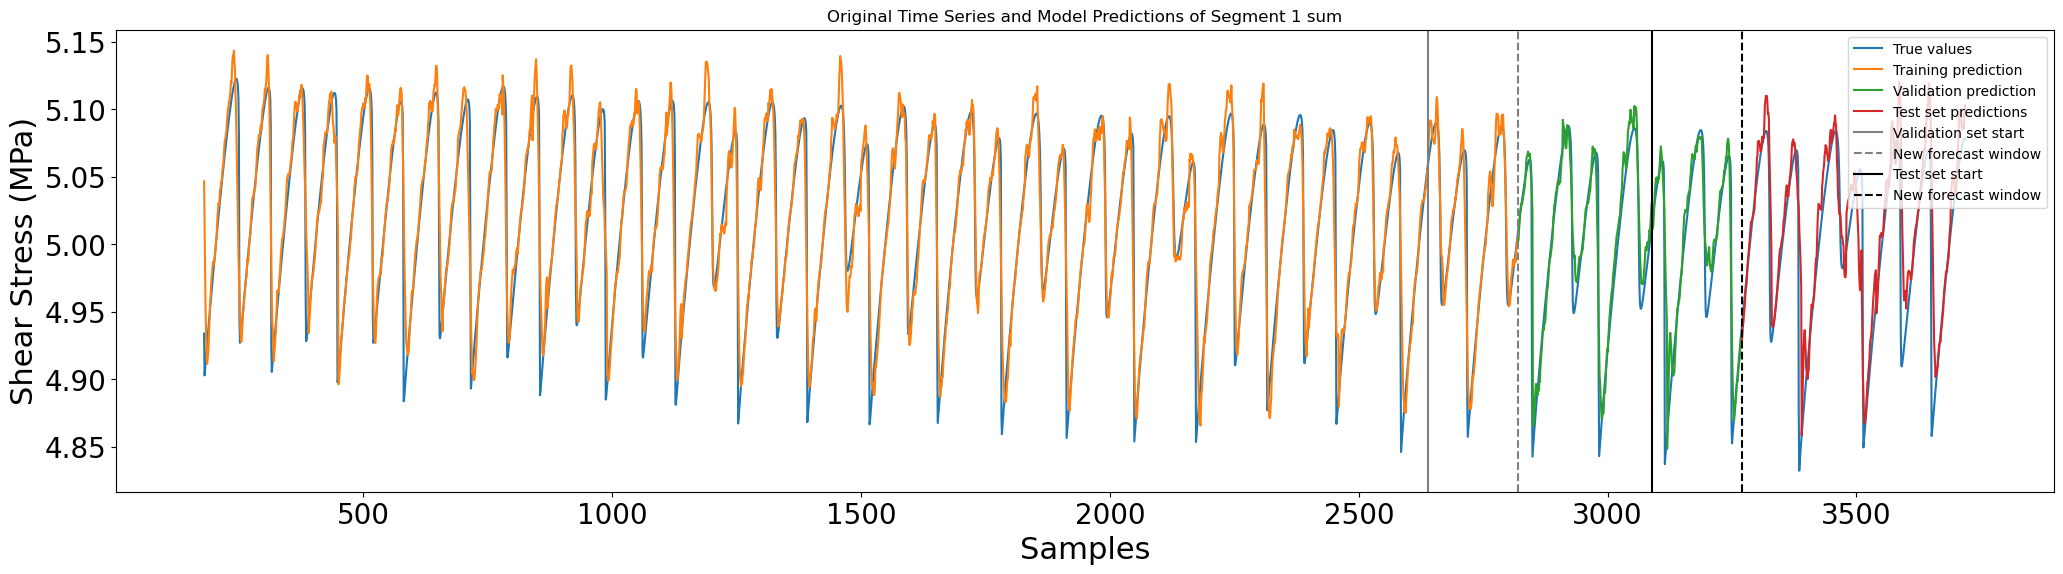

In [52]:
plot_all_data_results(
    data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, []
)
# TODO: CHANGE HORRIBLE COLOURS

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

matplotlib.rcParams["animation.embed_limit"] = (
    2**128
)  # Adjust the limit as necessary

# Setup plotting preferences
lookback, forecast = LOOKBACK, FORECAST
s = 5
window = 700

# Combined true value data updated with validation set
combined_true = np.concatenate(
    (
        data_dict["y_train"][:, 0],
        data_dict["y_val"][:, 0],
        np.zeros(window - lookback),
    )
)

combined_pred = np.concatenate(
    (
        results_dict["y_train_pred"][:, :],
        results_dict["y_val_pred"][:, :],
    )
)

# Initialize figure
fig, ax = plt.subplots(figsize=(25, 6))

# Set nicer colors
true_values_color = "#3498db"  # Blue
forecast_color = "#e74c3c"  # Red
lookback_color = "#f39c12"  # Orange
forecast_box_color = "#e74c3c"  # Red

# Set static elements of the plot
ax.set_title("Laboratory TCN Forecasts", fontsize=26)
ax.set_xlabel("Samples", fontsize=22)
ax.set_ylabel("Shear Stress (MPa)", fontsize=22)

# Prepare your data here...

# Define the update function for the animation


def update(frame):

    # Clear only the data elements of the plot
    ax.cla()

    # Compute start and end indices for the current frame
    start_idx = max(frame, 0)
    end_idx = start_idx + window

    # Determine colors: white for zero values, blue (or any other color) for non-zero values
    colors = np.where(
        combined_true[start_idx:end_idx] == 0, "white", true_values_color
    )  # Conditional color assignment
    # Ensure your data indexing accounts for the structure of combined_plot and combined_true
    ax.scatter(
        range(start_idx, end_idx),
        combined_true[start_idx:end_idx],
        label="True values",
        s=s,
        color=colors,
    )

    # Highlight lookback window
    lookback_box = Rectangle(
        (start_idx, 4.8),
        lookback,
        5.15 - 4.8,
        alpha=0.1,
        color=lookback_color,
        label="Lookback Window",
    )
    ax.add_patch(lookback_box)

    # Highlight forecast point - adjust as necessary to highlight the specific forecast period or points
    forecast_box = Rectangle(
        (lookback + start_idx, 4.8),
        forecast,
        5.15 - 4.8,
        alpha=0.2,
        color=forecast_box_color,
        label="Forecast Period",
    )
    ax.add_patch(forecast_box)

    ax.scatter(
        range(lookback + start_idx, lookback + start_idx + forecast),
        combined_pred[lookback + frame, :],
        label="Forecast predictions",
        s=s,
        color=forecast_color,
    )

    # Re-apply labels and legends since ax.cla() clears them
    ax.set_xlabel("Samples", fontsize=22)
    ax.set_ylabel("Shear Stress (MPa)", fontsize=22)
    ax.set_title("Laboratory TCN Forecasts", fontsize=26)
    ax.set_ylim(4.8, 5.15)
    ax.legend(loc="upper right", fontsize=16)


# Calculate the total number of frames needed
# This depends on how you wish to step through the data and the length of your data
total_frames = len(combined_true) - window

# Create the animation
ani = FuncAnimation(
    fig, update, frames=total_frames, repeat=False, interval=20
)

# # Save the animation
# ani.save('my_animation.mp4', writer='ffmpeg', fps=10, dpi=100)

# If you're in a Jupyter notebook, display the animation
HTML(ani.to_jshtml())

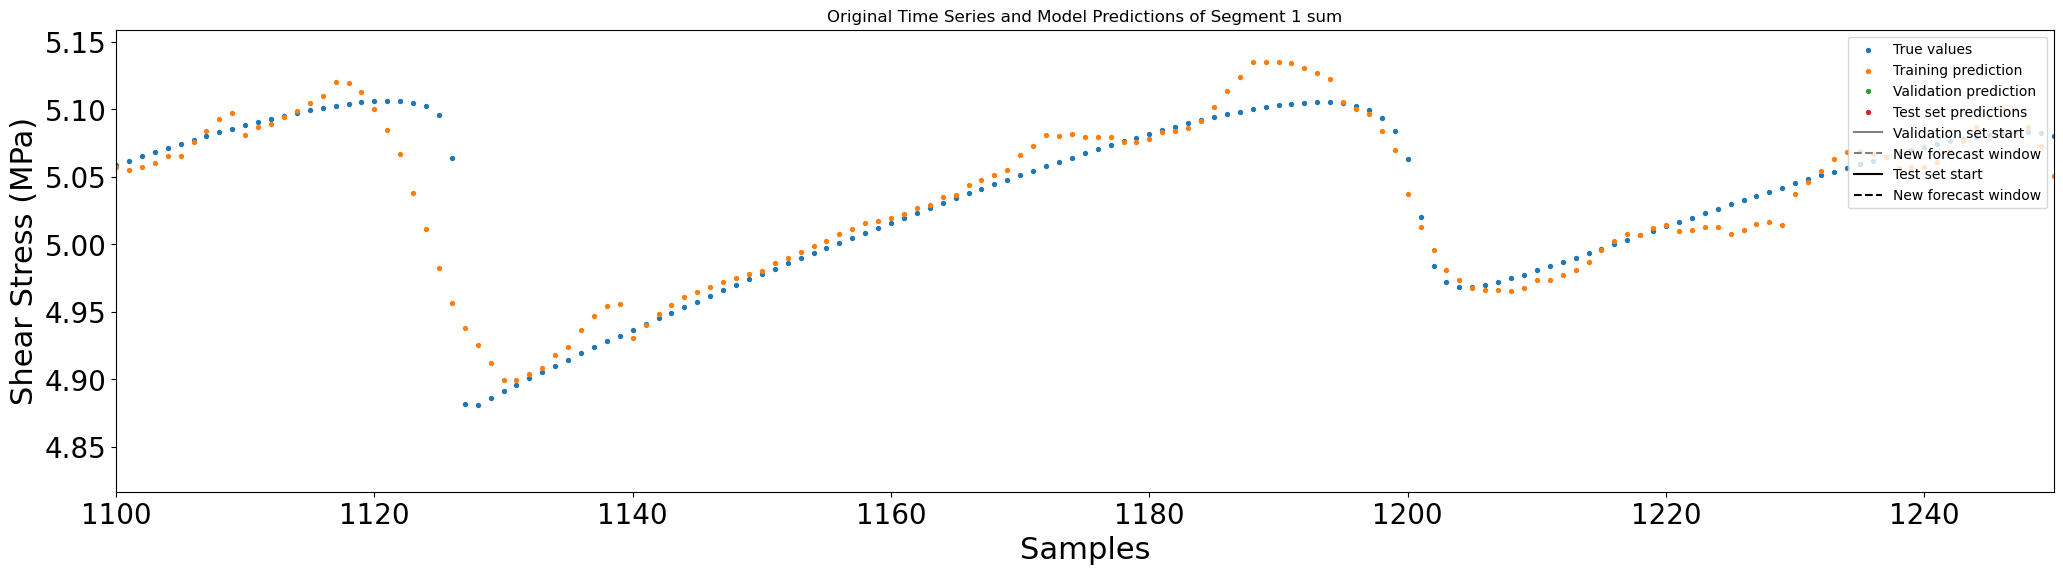

In [54]:
plot_all_data_results(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    TITLE,
    X_LABEL,
    Y_LABEL,
    ZOOM_WINDOW,
    plot_type="scatter",
)
# LOOK AT BOKE

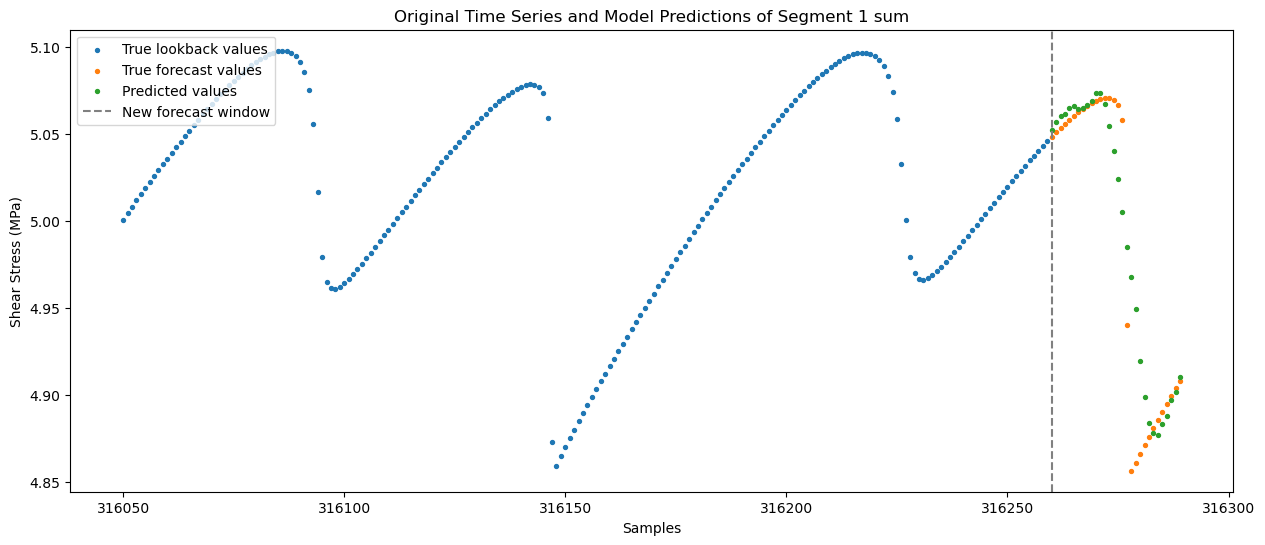

In [55]:
plot_single_seg_result(
    data_dict,
    results_dict,
    LOOKBACK,
    FORECAST,
    1505,
    TITLE,
    X_LABEL,
    Y_LABEL,
    save_plot=False,
)

In [56]:
import numpy as np
import torch
import torch.nn as nn

y_test_true = data_dict["y_test"]
y_test_pred = results_dict["y_test_pred"]

array_loss_fn = nn.MSELoss(reduction="none")

# with torch.no_grad():
loss = array_loss_fn(y_test_pred, y_test_true)

rmse = np.sqrt(loss)
avg_test_rmse = np.sqrt(torch.mean(loss, dim=1))
test_rmse_first = np.sqrt(loss[:, 0])
test_rmse_last = np.sqrt(loss[:, -1])

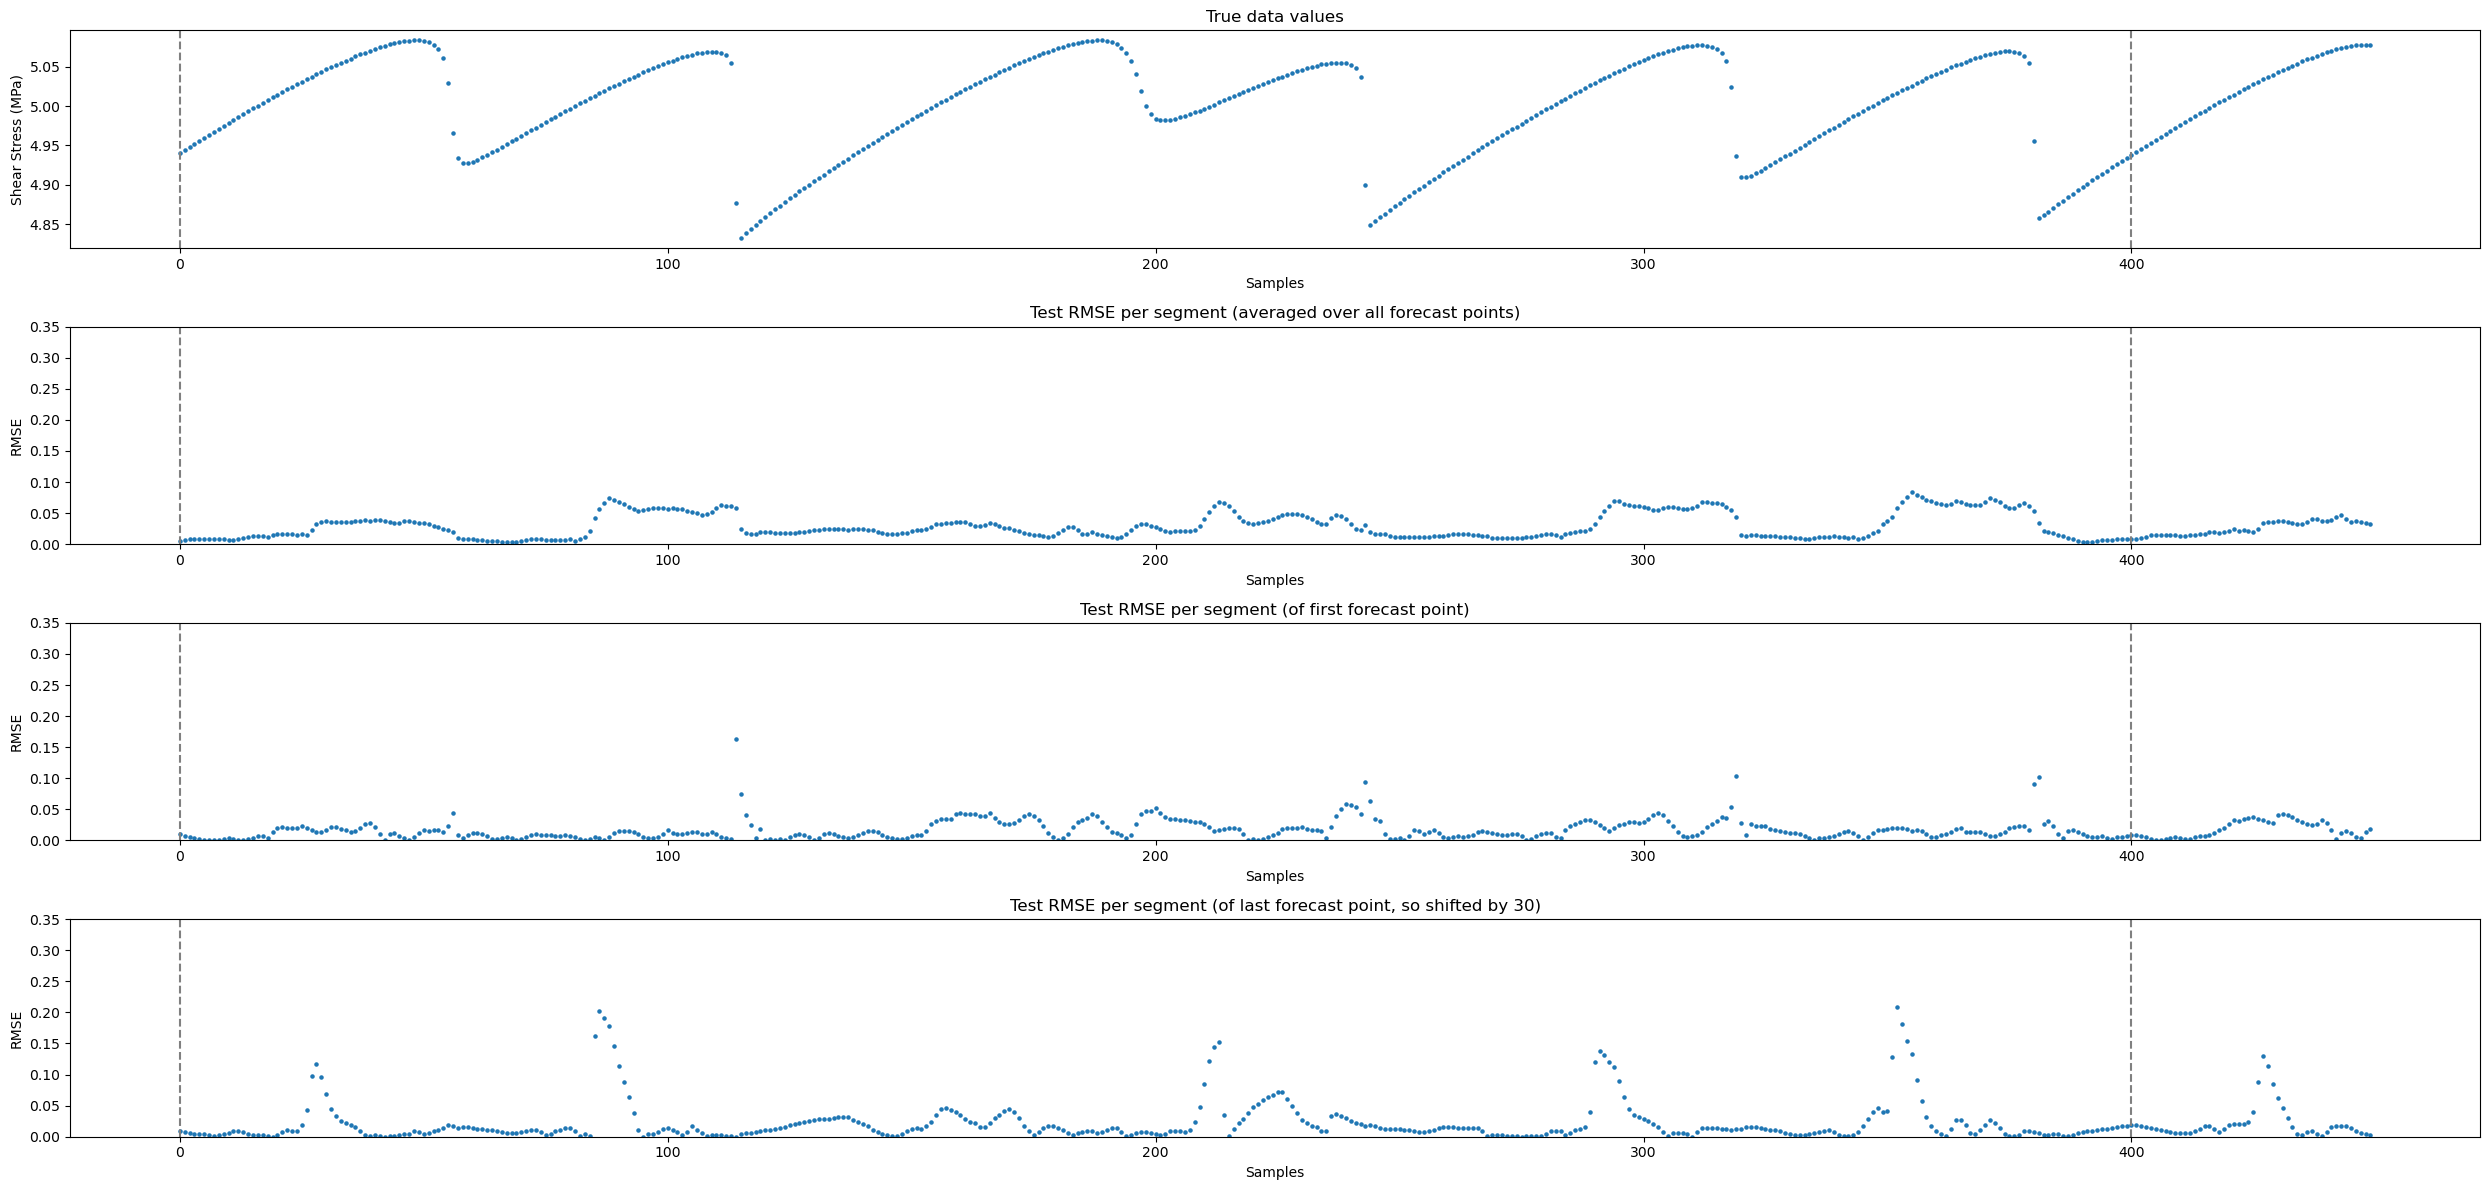

In [57]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 1, figsize=(25, 12))
n_samples = len(data_dict["y_test"])

# First subplot
for x in np.arange(0, n_samples, 400):
    axs[0].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to first subplot
    axs[1].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot
    axs[2].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot
    axs[3].axvline(
        x=x, color="grey", linestyle="--"
    )  # Add vertical lines to second subplot

axs[0].scatter(
    range(len(data_dict["y_test"][:, 0])), data_dict["y_test"][:, 0], s=5
)
axs[0].set_title("True data values")  # Add a title
axs[0].set_xlabel(X_LABEL)  # Set X-axis label
axs[0].set_ylabel(Y_LABEL)  # Set Y-axis label

rmse_ymax = 0.35

# Second subplot
axs[1].scatter(range(len(avg_test_rmse)), avg_test_rmse, s=5)
axs[1].set_title(
    "Test RMSE per segment (averaged over all forecast points)"
)  # Add a title
axs[1].set_xlabel(X_LABEL)  # Set X-axis label
axs[1].set_ylabel("RMSE")  # Set Y-axis label
axs[1].set_ylim([0, rmse_ymax])  # Set y-axis range from 0 to 1

# Second subplot
axs[2].scatter(range(len(test_rmse_first)), test_rmse_first, s=5)
axs[2].set_title(
    "Test RMSE per segment (of first forecast point)"
)  # Add a title
axs[2].set_xlabel(X_LABEL)  # Set X-axis label
axs[2].set_ylabel("RMSE")  # Set Y-axis label
axs[2].set_ylim([0, rmse_ymax])  # Set y-axis range from 0 to 1

# Second subplot
axs[3].scatter(range(len(test_rmse_last)), test_rmse_last, s=5)
axs[3].set_title(
    f"Test RMSE per segment (of last forecast point, so shifted by {FORECAST})"
)  # Add a title
axs[3].set_xlabel(X_LABEL)  # Set X-axis label
axs[3].set_ylabel("RMSE")  # Set Y-axis label
axs[3].set_ylim([0, rmse_ymax])  # Set y-axis range from 0 to 1

plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

In [58]:
import numpy as np
import torch
import torch.nn as nn

y_test_true = data_dict["y_test"]
y_test_pred = results_dict["y_test_pred"]

array_loss_fn = nn.MSELoss(reduction="none")

with torch.no_grad():
    loss = array_loss_fn(y_test_pred, y_test_true)

    avg_test_rmse = np.sqrt(torch.mean(loss, dim=1))
    test_rmse_first = np.sqrt(loss[:, 0])
    test_rmse_last = np.sqrt(loss[:, -1])

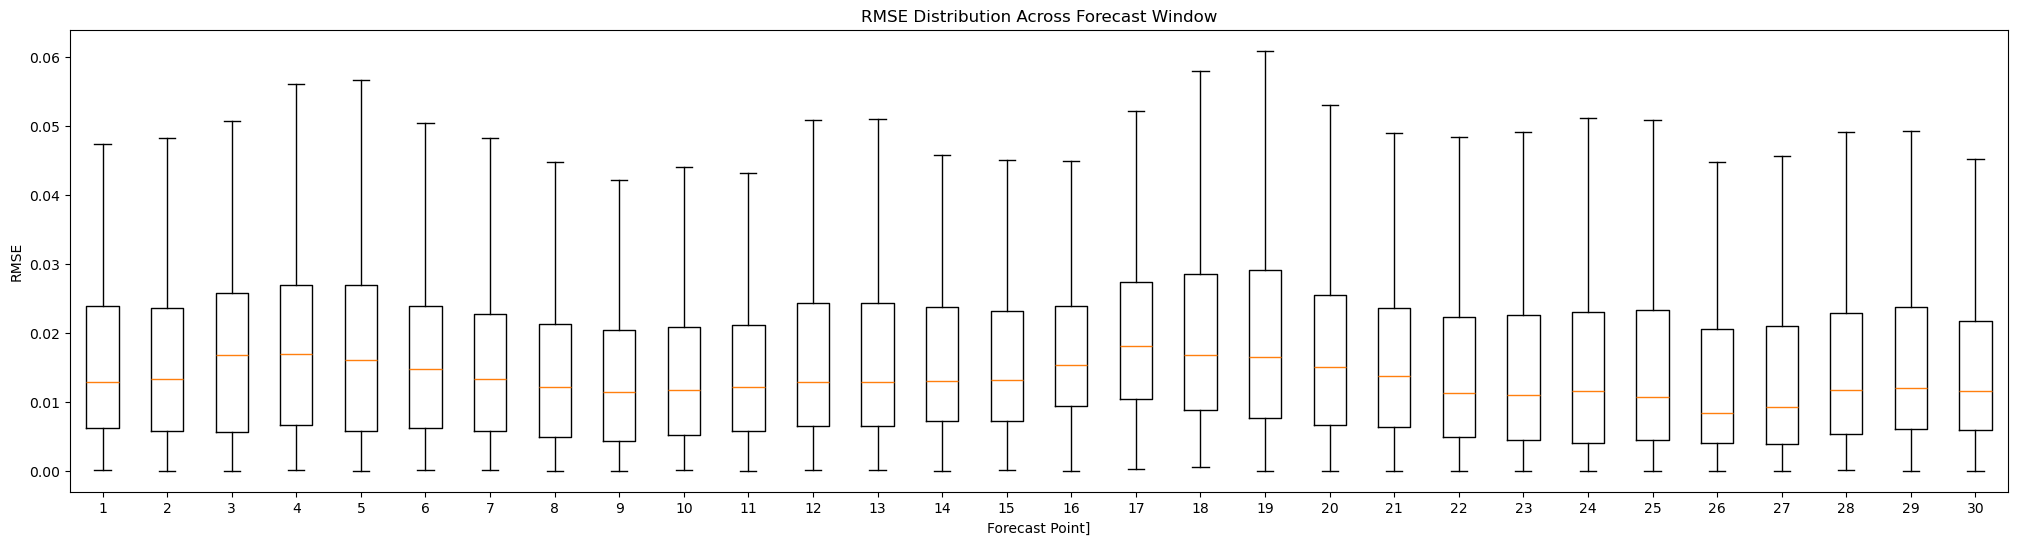

In [59]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(25, 6))
plt.boxplot(rmse.numpy(), showfliers=False)
ax.set_title("RMSE Distribution Across Forecast Window")
ax.set_xlabel("Forecast Point]")
ax.set_ylabel("RMSE")
ax.set_xticklabels([i + 1 for i in range(rmse.shape[1])])  # Label each boxplot
plt.show()